# Estimate the luminosity function of SDSS galaxies using SkyServer

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
"""
SELECT TOP 10000 s.z, p.petroMag_r
FROM Galaxy p
INNER JOIN SpecObjAll s ON s.bestObjID = p.objID
WHERE 
  s.survey = 'SDSS' AND
  s.z BETWEEN 0.01 AND 0.5    
"""

In [17]:
appmag = np.loadtxt("appmag_vs_z.csv", delimiter=",", skiprows=1)
appmag.shape

(10000, 2)

(20, 12.5)

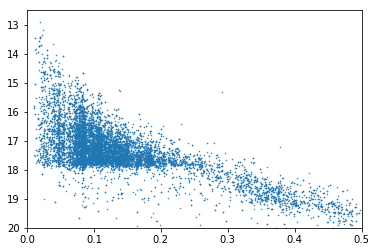

In [33]:
plot(appmag[:,0], appmag[:,1], ".", ms=1)
xlim([0,0.5])
ylim([20,12.5])

(20, 12.5)

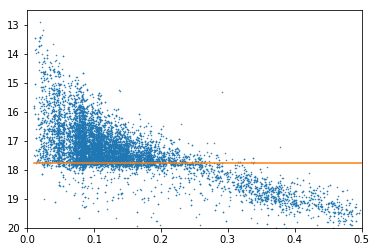

In [34]:
zz = linspace(0.01, 0.5, 20)
mag_limit = np.empty(len(zz))
mag_limit.fill(17.77)

plot(appmag[:,0], appmag[:,1], ".", ms=1)
plot(zz, mag_limit, '-')
xlim([0,0.5])
ylim([20,12.5])

# Excercise 2

Calculate absolute magnitudes. Use SQL functions and astropy

In [ ]:
"""
SELECT TOP 10000 
  s.z, 
  p.petroMag_r - p.extinction_r, 
  p.petroMag_r - extinction_r - 5 * LOG10(dbo.fCosmoDl(s.z, DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT)) - 25
FROM Galaxy p
INNER JOIN SpecObjAll s ON s.bestObjID = p.objID
WHERE 
  s.survey = 'SDSS' AND
  s.z BETWEEN 0.01 AND 0.5  
"""

In [24]:
absmag = np.loadtxt("absmag_vs_z.csv", delimiter=",", skiprows=1)
absmag.shape 

(10000, 3)

(-15, -24)

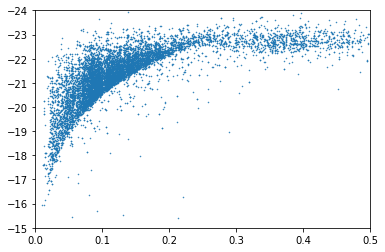

In [35]:
plot(absmag[:,0], absmag[:,2], ".", ms=1)
xlim([0,0.5])
ylim([-15,-24])

To explain the magnitude limit of the survey, plot the 17.77 mag curve

In [28]:
from astropy.cosmology import WMAP9 as cosmo
cosmo.luminosity_distance(0.1)

<Quantity 465.2805915046128 Mpc>

In [29]:
zz = np.linspace(0.01, 0.5, 20)
D_L = cosmo.luminosity_distance(zz).value
absmag_limit = 17.77 - 5 * np.log10(D_L) - 25

(-15, -24)

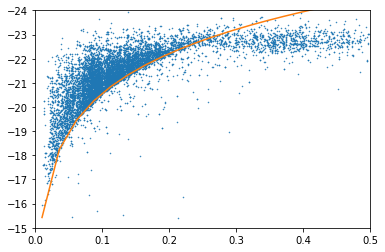

In [36]:
plot(absmag[:,0], absmag[:,2], ".", ms=1)
plot(zz, absmag_limit, '-')
xlim([0,0.5])
ylim([-15,-24])

## Excercise 3

* Explain the Malmquist bias, select a volume limited sample
* Explain why we use the WITH statement
* Explain why we had to move

* Have to add a ; before WITH to work around a bug in CasJobs

In [ ]:
"""
;
WITH q AS
(
SELECT
  s.z AS z, 
  p.petroMag_r - p.extinction_r AS mag_r, 
  p.petroMag_r - extinction_r - 5 * LOG10(dbo.fCosmoDl(s.z, DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT)) - 25 AS absmag_r
FROM Galaxy p
INNER JOIN SpecObjAll s ON s.bestObjID = p.objID
WHERE 
  s.survey = 'SDSS' AND
  s.z BETWEEN 0.01 AND 0.5  
)
SELECT TOP 10000 * FROM q
  WHERE z BETWEEN 0.01 AND 0.05 AND absmag_r BETWEEN -24 AND -19
"""

In [37]:
absmag_vl = np.loadtxt("absmag_vs_z_vl.csv", delimiter=",", skiprows=1)
absmag_vl.shape 

(10000, 3)

(-18.5, -23.5)

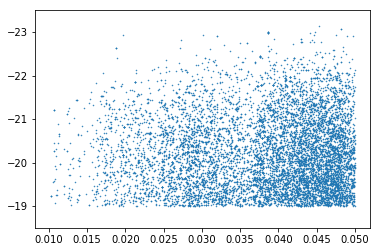

In [39]:
plot(absmag_vl[:,0],absmag_vl[:,2], '.', ms=1)
ylim([-18.5, -23.5])

## Excercise 4

Determine the histogram of the volume limited sample

In [ ]:
"""
DECLARE @binsize float = 0.01;

WITH q AS
(
SELECT
  s.z AS z, 
  p.petroMag_r - p.extinction_r AS mag_r, 
  p.petroMag_r - extinction_r - 5 * LOG10(dbo.fCosmoDl(s.z, DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT)) - 25 AS absmag_r
FROM Galaxy p
INNER JOIN SpecObjAll s ON s.bestObjID = p.objID
WHERE 
  s.survey = 'SDSS' AND
  s.z BETWEEN 0.01 AND 0.5  
),
hist AS
(
  SELECT FLOOR(absmag_r / @binsize) * @binsize AS bin
  FROM q
  WHERE z BETWEEN 0.01 AND 0.05 AND absmag_r BETWEEN -24 AND -19
)
SELECT bin, COUNT(*) 
FROM hist
GROUP BY bin
ORDER BY bin
"""

In [40]:
lumf = np.loadtxt("lumf.csv", delimiter=",", skiprows=1)
lumf.shape 

(423, 2)

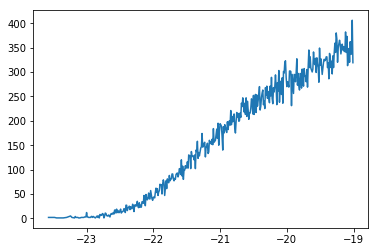

In [41]:
plot(lumf[:,0], lumf[:, 1], '-')

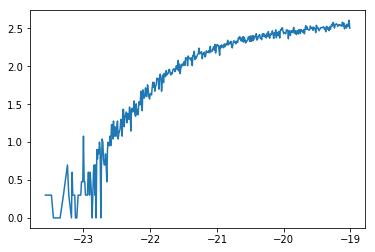

In [42]:
plot(lumf[:,0], np.log10(lumf[:, 1]), '-')

## Excercise 5

Determine the statistical error of the _logarithm_ of the histogram and fit with the maximum likelihood method using a Nelder-Mead or Levenberg-Marquard optimizer

Find the parameters of the Schechter function:

$$
 n(M) \ \mathrm{d}M = 0.4 \ \ln 10 \ \phi^*  [ 10^{ 0.4 ( M^* - M ) } ]^{ \alpha + 1}  \exp [ -10^{ 0.4 ( M^* - M ) } ] \ \mathrm{d}M
$$

In [44]:
lumf_err = 1 / np.sqrt(lumf[:,1]) / np.log(10)

<Container object of 3 artists>

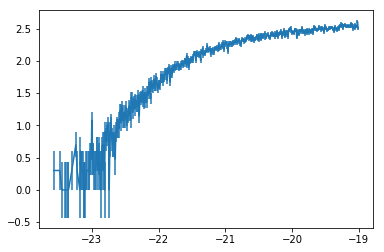

In [50]:
errorbar(lumf[:,0], np.log10(lumf[:, 1]), yerr=lumf_err)

Logarithm of the Schechter function

$$
\log_{10} n(M) = C + 0.4(M^*-M)(\alpha+1)-\frac{10^{0.4(M^*-M)}}{\log_{10} \mathrm{e}}
$$

In [135]:
def LogSchechter(M, log_phi_0, M_star, alpha):
    return log_phi_0 + 0.4 * (M_star - M) * (alpha - 1) - 10**(0.4 * (M_star - M)) / np.log(10)

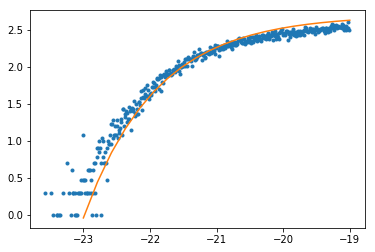

In [161]:
MM = np.linspace(-23, -19, 20)

plot(lumf[:,0], np.log10(lumf[:, 1]), '.')
plot(MM, LogSchechter(MM, 2.7, -21.0, 1), '-')

In [163]:
from scipy.optimize import curve_fit
p, popt = curve_fit(LogSchechter, lumf[:,0], np.log10(lumf[:, 1]), p0=[2.7, -21.0, 1])
p, popt

(array([  2.40961741, -21.49102546,   0.75264247]),
 array([[ 0.00053414,  0.00063408,  0.00065054],
        [ 0.00063408,  0.00084106,  0.00082169],
        [ 0.00065054,  0.00082169,  0.00101543]]))

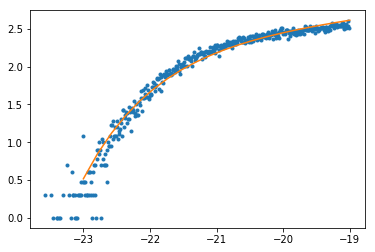

In [164]:
plot(lumf[:,0], np.log10(lumf[:, 1]), '.')
plot(MM, LogSchechter(MM, p[0], p[1], p[2]), '-')

Now fit with errors

In [165]:
p, popt = curve_fit(LogSchechter, lumf[:,0], np.log10(lumf[:, 1]), p0=[2.7, -21.0, 1], sigma=lumf_err)
p, popt

(array([  2.57213212, -21.27654184,   0.97356893]),
 array([[  9.03339256e-05,   1.74758473e-04,   1.12714452e-04],
        [  1.74758473e-04,   3.80135429e-04,   2.13672308e-04],
        [  1.12714452e-04,   2.13672308e-04,   1.54053781e-04]]))

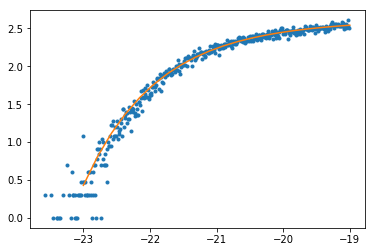

In [166]:
plot(lumf[:,0], np.log10(lumf[:, 1]), '.')
plot(MM, LogSchechter(MM, p[0], p[1], p[2]), '-')